<a href="https://colab.research.google.com/github/Kab121/brain-mri-tumour-classifier/blob/main/brain_mri_tumour_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q gradio


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pathlib, zipfile, os
import gradio as gr


In [4]:
# Path to your dataset zip (after you upload it in Colab "Files" -> /content/)
dataset_zip = "/content/BrainTumorDataset.zip"   # 🔁 change name if different

# Unzip to /content/
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Root folder of extracted dataset
data_dir = pathlib.Path("/content/BrainTumorDataset")
print("Dataset root:", data_dir)

# Train / Validation / Test folders
train_dir = data_dir / "Training"
val_dir   = data_dir / "Validation"
test_dir  = data_dir / "Testing"

print("Train dir :", train_dir)
print("Val dir   :", val_dir)
print("Test dir  :", test_dir)


Dataset root: /content/BrainTumorDataset
Train dir : /content/BrainTumorDataset/Training
Val dir   : /content/BrainTumorDataset/Validation
Test dir  : /content/BrainTumorDataset/Testing


In [5]:
img_height, img_width = 180, 180
batch_size = 32

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Test dataset (no shuffle so labels line up with predictions)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 2550 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Classes: ['glioma', 'notumor', 'pituitary']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


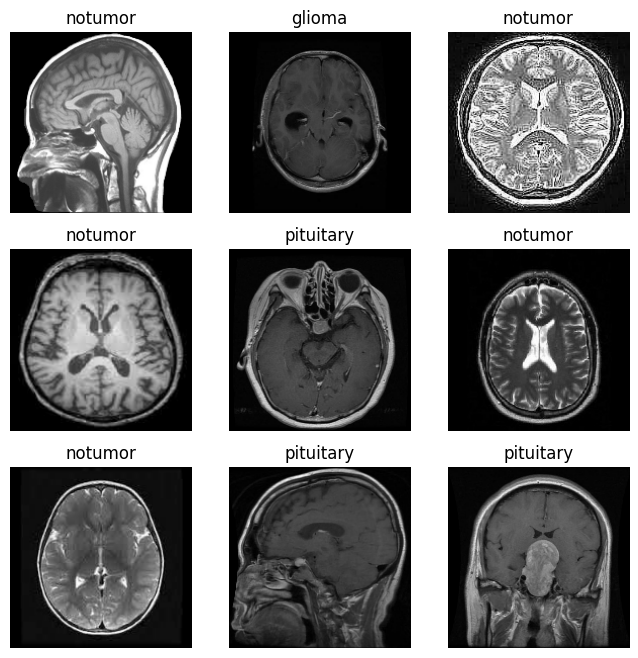

In [7]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')   # probabilities for 3 classes
])

model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Extract all training labels from dataset
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.7), 1: np.float64(0.5483870967741935), 2: np.float64(1.7)}


In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.6516 - loss: 0.7500 - val_accuracy: 0.8511 - val_loss: 0.5284
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8890 - loss: 0.3382 - val_accuracy: 0.9311 - val_loss: 0.2420
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.8994 - loss: 0.2580 - val_accuracy: 0.9178 - val_loss: 0.2426
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9186 - loss: 0.2236 - val_accuracy: 0.9200 - val_loss: 0.3317
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9388 - loss: 0.1969 - val_accuracy: 0.8867 - val_loss: 0.4647


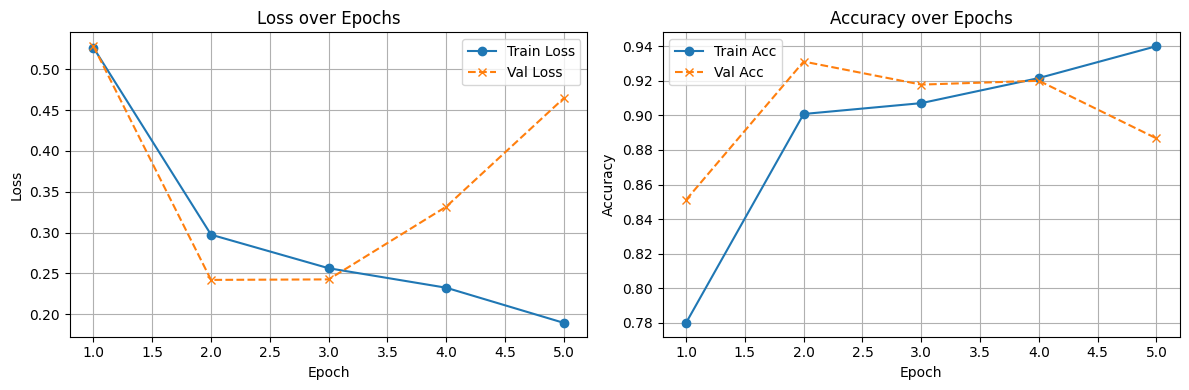

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, 'o-', label='Train Loss')
    plt.plot(epochs_range, val_loss, 'x--', label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs')
    plt.grid(True); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, acc, 'o-', label='Train Acc')
    plt.plot(epochs_range, val_acc, 'x--', label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over Epochs')
    plt.grid(True); plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [12]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.8905 - loss: 0.4213

Test Loss: 0.3884
Test Accuracy: 0.8889


29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 991ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.82      0.87       300
     notumor       0.90      0.98      0.94       300
   pituitary       0.84      0.87      0.85       300

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



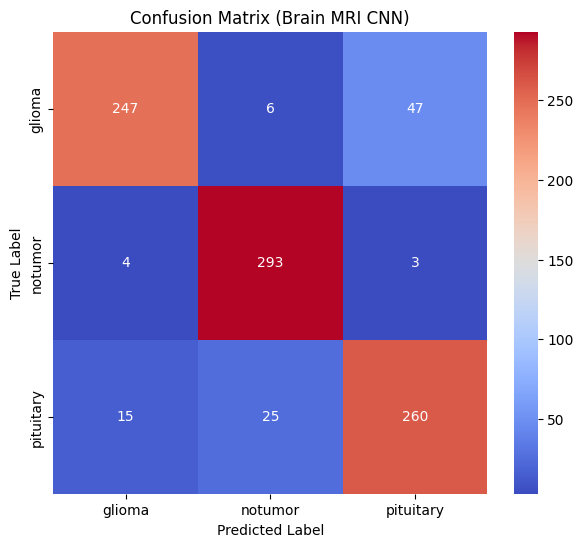

In [13]:
# Collect true labels
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Brain MRI CNN)")
plt.show()


In [14]:
model.save("brain_mri_cnn.h5")
print("Model saved as brain_mri_cnn.h5")


Model saved as brain_mri_cnn.h5


In [15]:
def predict_brain_mri(image):
    """
    image: PIL Image from Gradio
    returns: dict {class_name: probability}
    """
    if image is None:
        return {}

    # Ensure RGB and correct size
    image = image.convert("RGB")
    image = image.resize((img_width, img_height))

    img_array = np.array(image)      # shape (H, W, 3)
    img_array = np.expand_dims(img_array, axis=0)  # shape (1, H, W, 3)

    # Model already has Rescaling(1./255) inside
    preds = model.predict(img_array)[0]  # first (and only) sample

    # Map to class names
    return {class_names[i]: float(preds[i]) for i in range(num_classes)}


In [16]:
demo = gr.Interface(
    fn=predict_brain_mri,
    inputs=gr.Image(type="pil", label="Upload Brain MRI"),
    outputs=gr.Label(num_top_classes=3, label="Prediction"),
    title="Brain MRI Tumour Classifier",
    description=(
        "Convolutional Neural Network that classifies brain MRI images into "
        "glioma, pituitary, or no-tumour."
    )
)

demo.launch(share=False)   # set share=True if you want a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>